# An XGB model to estimate the price of a diamond

## 0. Imports

First are all the imports needed for the project.

In [2]:
import math
import os
from contextlib import redirect_stdout
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split

## 1. Data pre-processing

We start by loading the dataset and removing one column of indexes as well as duplicates. Before that, however, we save the length of the dataset to know later how much data was filtered out. We also look at what the dataset looks like with the .head() method.

In [3]:
df = pd.read_csv('diamonds.csv')

start_len = df.shape[0]

df.drop_duplicates(inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

display(df.head())

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 1.1 Visualisation

We create some graphs to visualize the data.

Here, a function is created that compares each column with the price and draws a point for each diamond. We can skip *cut*, *color* and *clarity* because they are categorical.

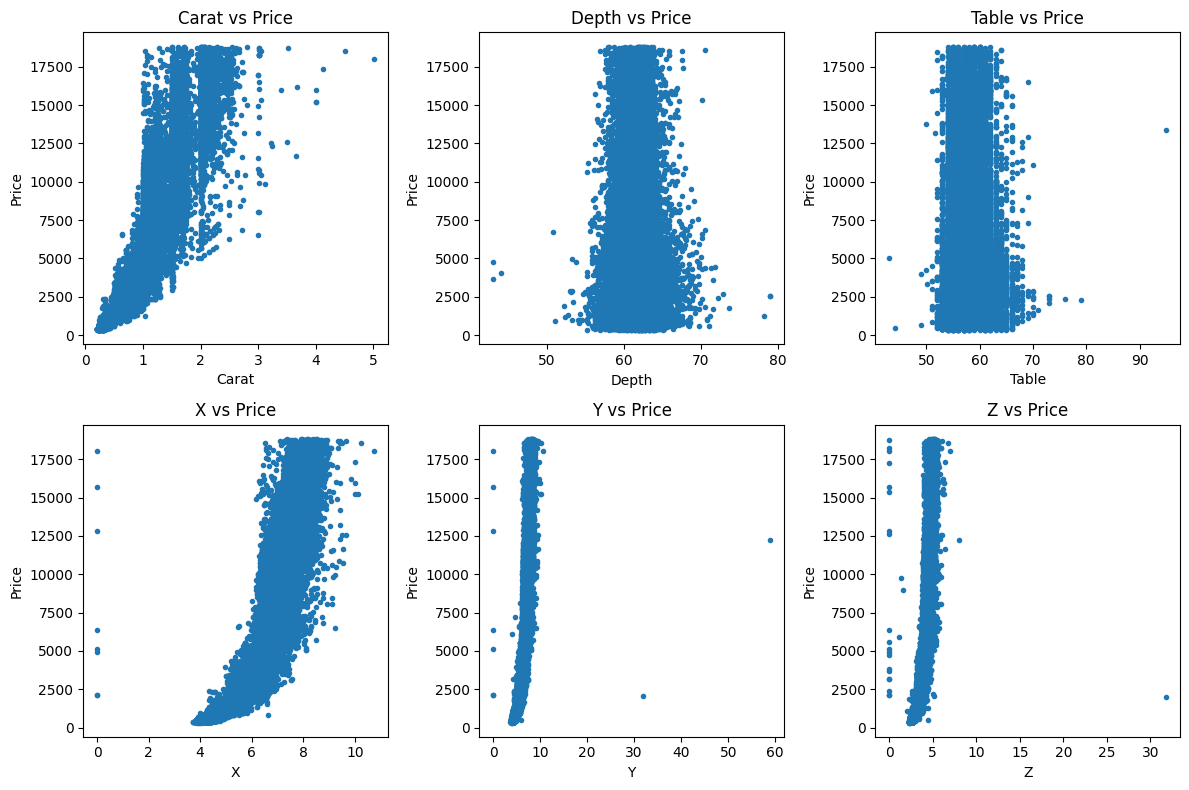

In [4]:
def plot_statistics():
    '''Draws a comparison between price and all other columns'''

    plt.figure(figsize=(12, 8))
    for n, column in enumerate(df.drop(columns=['price', 'cut', 'color', 'clarity']).columns, 1):
        plt.subplot(2, 3, n)
        plt.scatter(df[column], df['price'], s=9)
        plt.xlabel(column.capitalize())
        plt.ylabel('Price')
        plt.title(f'{column.capitalize()} vs Price')

    plt.tight_layout()

plot_statistics()

## 1.2 Pre-processing

We see that in several places, there are points that stand out a lot from the rest of the data, and therefore we want to filter them out.

From the graph, we see that some of the diamonds' *y* or *z* are zero. There are also some that have very large values. A diamond that is missing a dimension, or has an unreasonable size is not very good to include in the training data, so we remove them.

In [5]:
df.drop(df[df['y'] == 0].index, inplace=True)
df.drop(df[df['y'] > 20].index, inplace=True)

df.drop(df[df['z'] < 2].index, inplace=True)
df.drop(df[df['z'] > 6].index, inplace=True)

Also in the columns *depth* and *table* there are values that stand out a lot.

In [6]:
df.drop(df[df['depth'] < 47.5].index, inplace=True)
df.drop(df[df['depth'] > 77.5].index, inplace=True)

df.drop(df[df['table'] < 45].index, inplace=True)
df.drop(df[df['table'] > 72.5].index, inplace=True)

So, how does it look after all this?

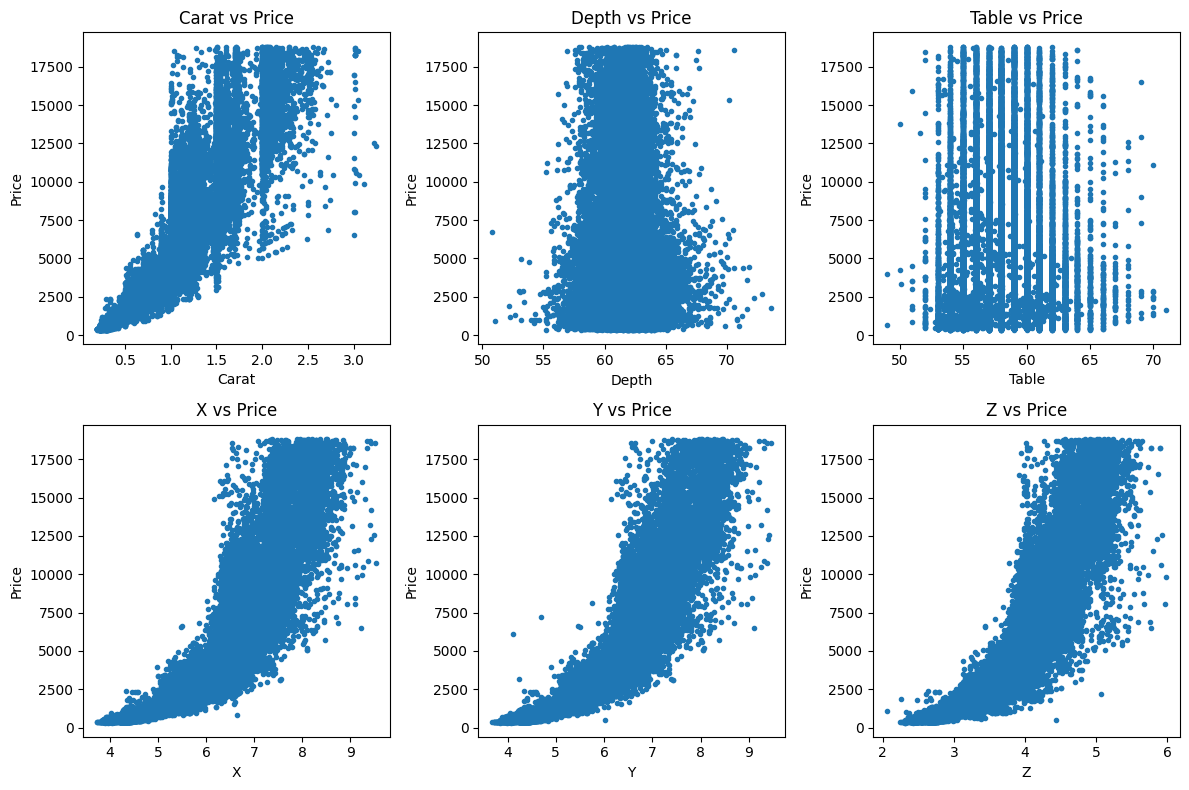

In [7]:
plot_statistics()

Since we saved the length of data at the beginning, we can now print out how much has been filtered out.

In [8]:
current_len = df.shape[0]
print(f'{start_len - current_len} of {current_len} or {(start_len - current_len) / start_len:.4f}% of datapoints removed')

51 of 53889 or 0.0009% of datapoints removed


There are still some columns that have categorical values (*cut*, *color*, *clarity*). This cannot be fed to the model, so `pd.get_dummies()` is used to convert each column of categorical values to individual columns for each category and then True and False are used to mark which category that row had. The columns of categorical values are removed after the individual columns have been created.

In [9]:
print('Before:')
display(df.head())

encoded_df = pd.get_dummies(df, prefix_sep=': ')

print('After:')
display(encoded_df.head())

Before:


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


After:


,carat,depth,table,price,x,y,z,cut: Fair,cut: Good,cut: Ideal,...,color: I,color: J,clarity: I1,clarity: IF,clarity: SI1,clarity: SI2,clarity: VS1,clarity: VS2,clarity: VVS1,clarity: VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,3.89,3.84,2.31,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,4.05,4.07,2.31,False,True,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,False,True,False,...,False,True,False,False,False,True,False,False,False,False


## 2. Creating a model

Now it's time to build a model. In this project, an eXtreme Gradient Booster is used. It is based on iteratively building Decision Tree models and with each iteration learning from the last. 

First, the data is split for training and testing. The split is 0.2, thus 80% goes to training and 20% to testing.

In [9]:
X = encoded_df.drop(columns='price')
y = encoded_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

We create the most basic version to test how well it works.

In [10]:
model = xgb.XGBRegressor(random_state=2)
model.fit(X_train, y_train);

Now we can do some visualization on its performance. On the graphs, we can also draw a line showing where the points should be in the best case. In the first graph, it's where the models prediction is the same as the real price. In the second graph, it is where the delta between the model and the real price is zero. With the function we also print the usual performance values MAE, MSE, RMSE.

Mean Absolute Error (MAE):      282
Mean Squared Error (MSE):       282758
Root Mean Squared Error (RMSE): 532


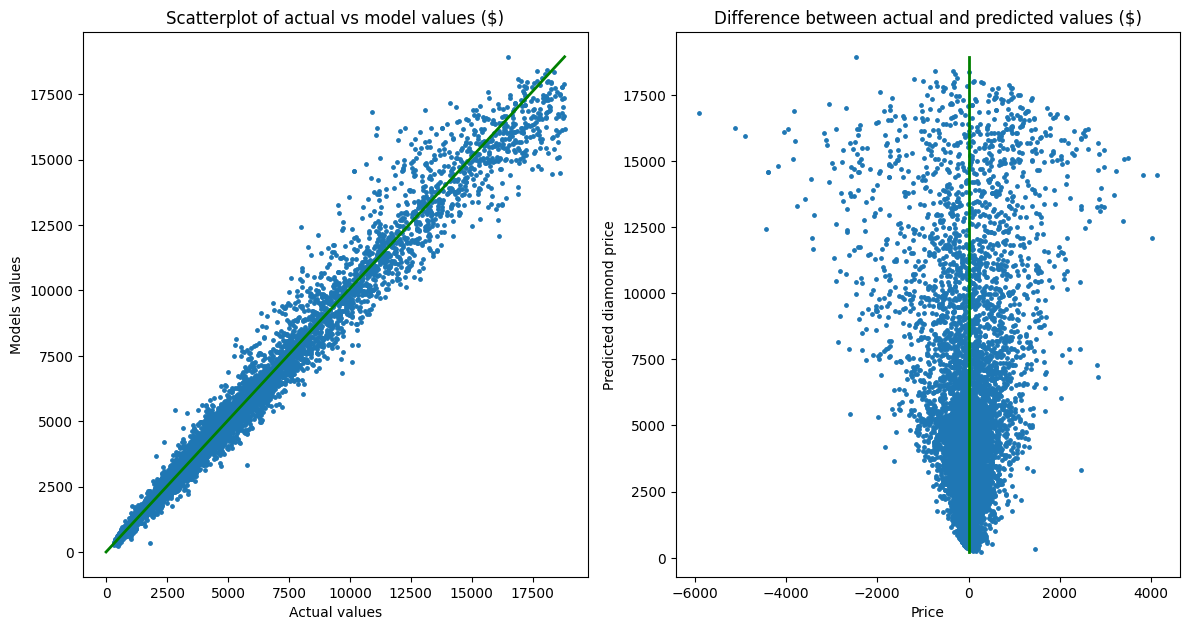

In [ ]:
def plot_perf(model):
    '''Creates a graph showing a model's performance'''

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f'Mean Absolute Error (MAE):      {mae:.0f}')
    print(f'Mean Squared Error (MSE):       {mse:.0f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.0f}')

    # Scatterplot (actual vs model)
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred, s=6)
    plt.plot([0, max(y_test)], [0, max(y_pred)], 'g', linewidth=2)
    plt.xlabel('Actual values')
    plt.ylabel('Models values')
    plt.title('Scatterplot of actual vs model values ($)')

    # Scatterplot (delta wrong)
    difference = y_test - y_pred
    plt.subplot(2, 2, 2)
    plt.scatter(difference, y_pred, s=6)
    plt.plot([0, 0], [min(y_pred), max(y_pred)], 'g', linewidth=2)
    plt.xlabel('Price')
    plt.ylabel('Predicted diamond price')
    plt.title('Difference between actual and predicted values ($)')

    plt.tight_layout()

plot_perf(model)

# 3. Adjust and improve

A model like this can take many parameters, all of which affect its accuracy. There are tools that are made to test several combinations to find the best possible one. The two most common are gridSearch and randomizedSearch. Grid tests all possible combinations, while randomized tests randomly selected hyperparameters a fixed number of times. Grid is guaranteed to find the best model, but random can find something still good, in far fewer tries.

We also configure early_stopping_rounds to save time. The model will then stop training early if the model does not improve over the number of iterations specified, in this case 10. However, this requires us to split the data again for a validation set to use during training.

In [12]:
X_search, X_val, y_search, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2)

param_dist = {
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5],   # How quickly values change at each iteration
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800],           # Number of steps to train the model

    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],                              # Maximum depth for each tree
    'min_child_weight': [1, 2, 3, 4, 5],                                    # How much is needed for the tree to split
    'gamma': [0, 1, 2, 3, 4, 5, 6],                                         # Minimum requirement of improvement, for the tree to split

    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1],                       # Proportion of columns included at each split in the tree
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],                              # Percentage of training data included in the training of each tree
}

print(f'Number of possible combinations: {math.prod(len(value) for value in param_dist.values()):,}')

rs = RandomizedSearchCV(
    xgb.XGBRegressor(
        early_stopping_rounds=10,
        random_state=2,
    ),
    param_dist,
    n_iter=250,
    n_jobs=-1,
    random_state=2
)

Number of possible combinations: 918,540


Now we can run randomizedSearch. The function is called within a with statement to pick up some unnecessary output.

In [13]:
with redirect_stdout(StringIO()):
    rs.fit(
        X_search,
        y_search,
        eval_set=[(X_val, y_val)]
    )

With randomizedSearch, we have now tested 250 combinations of hyperparameters. GridSearch had done 918,540. Now, let's see how good this model is.

Mean Absolute Error (MAE):      274
Mean Squared Error (MSE):       272977
Root Mean Squared Error (RMSE): 522


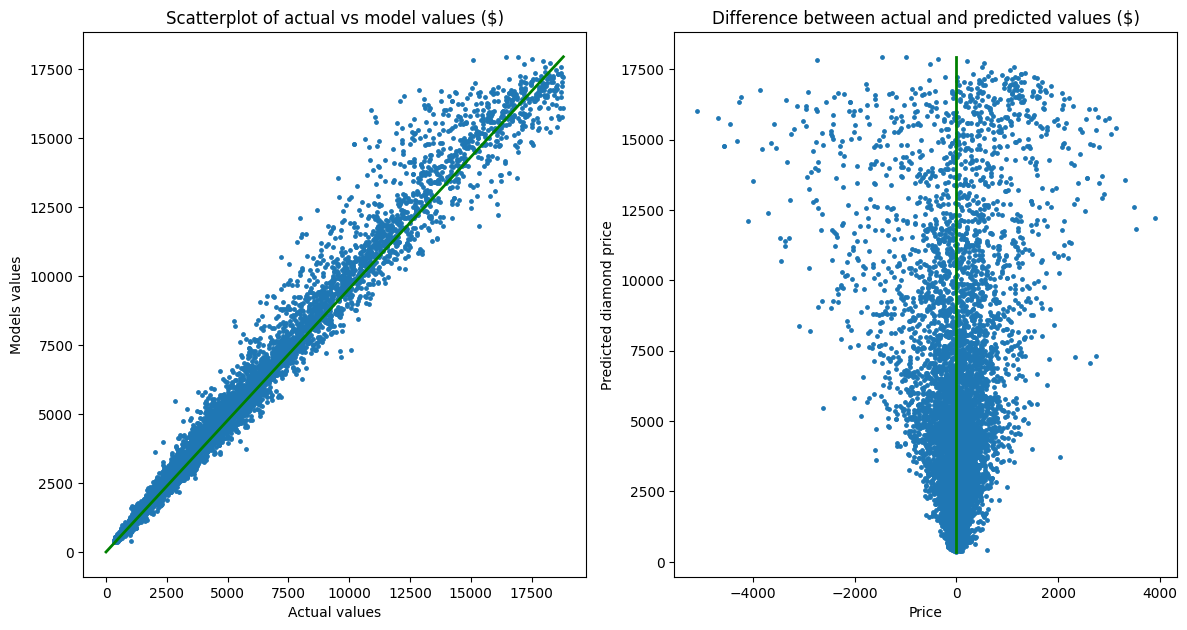

In [14]:
plot_perf(rs.best_estimator_) 

Now that we have a good model, we can save it to the models folder. It still takes a while to run randomizedSearch, and we don't want to do that every time the model is used. The name will be a score returned by randomizedSearch. If the model is not better than any already saved, it won't be saved at all.

In [15]:
def save_best_model(rs: RandomizedSearchCV) -> None:
    '''Save the model if it is better than the previously saved ones'''

    # Create a folder for models if there is not one yet
    if not os.path.exists('models'):
        os.mkdir('models')

    saved_scores = [float(file.rsplit('.', maxsplit=1)[0]) for file in os.listdir('models') if file.endswith('.ubj')]

    best_saved = max(saved_scores) if saved_scores else 0

    if rs.best_score_ > best_saved:
        rs.best_estimator_.save_model(f'models/{rs.best_score_}.ubj')
        print('The model is better and has been saved')

save_best_model(rs)

# 4. Demo

It's always interesting to look at some real predictions with the best model available. First, we load the best of our saved models.

In [16]:
def load_best_model() -> xgb.Booster:
    '''Loads the best saved model'''

    best_score = max(float(file.rsplit('.', maxsplit=1)[0]) for file in os.listdir('models') if file.endswith('.ubj'))

    best_model = xgb.XGBRegressor()
    best_model.load_model(f'models/{best_score}.ubj')

    return best_model

best_model = load_best_model()

Now we can select some random rows within the data and make some predictions. In addition, the indices of the randomly selected rows are restored and then merged.

In [17]:
indices = np.random.choice(df.shape[0], 10, False)

df_demo = df.iloc[indices].reset_index(drop=True)
X_demo = X.iloc[indices].reset_index(drop=True)
y_demo = y.iloc[indices].reset_index(drop=True)

preds = best_model.predict(X_demo)

df_demo.drop(columns=['price'], inplace=True)
y_demo = pd.DataFrame({'actual price': y_demo})
preds_demo = pd.DataFrame({'predicted price': preds}).round().astype('int')

Finally, we put the values together in a DataFrame and run .capitalize() for better visualization.

In [18]:
demo = pd.concat((df_demo, y_demo, preds_demo), axis=1)
demo.columns = [col.capitalize() for col in demo.columns]

display(demo)

,Carat,Cut,Color,Clarity,Depth,Table,X,Y,Z,Actual price,Predicted price
0,0.31,Ideal,E,VVS2,60.9,55.0,4.42,4.45,2.70,864,876
1,1.05,Very Good,E,VS2,61.6,58.0,6.48,6.53,4.01,6803,6746
2,1.11,Ideal,G,SI1,62.6,57.0,6.64,6.56,4.13,5428,5310
3,0.24,Very Good,F,VVS2,62.1,58.0,3.96,4.03,2.48,478,554
4,0.32,Ideal,G,VVS1,61.1,53.0,4.44,4.40,2.70,1080,874
5,0.70,Ideal,F,VS1,62.0,55.0,5.71,5.74,3.55,2726,3148
6,0.30,Ideal,E,VVS2,61.8,56.0,4.33,4.31,2.67,1013,878
7,0.50,Premium,G,VS1,60.9,58.0,5.23,5.09,3.14,1746,1671
8,0.32,Premium,I,VS1,61.0,60.0,4.42,4.47,2.71,505,562
9,0.33,Premium,I,VS2,62.6,58.0,4.42,4.34,2.74,594,553
